In [26]:
####

In [41]:
import torch
from torch.utils.data import DataLoader , Dataset
from torchvision import datasets , transforms
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchsummary import summary
import random

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def show_tensor_images(image_tensor, num_images=2, size=(1 , 28 , 28)):
  image_shifted = image_tensor
  image_unflat = image_shifted.detach().cpu().view(-1, *size)
  image_grid = make_grid(image_unflat[:num_images], nrow=5)
  plt.imshow(image_grid.permute(1, 2, 0).squeeze())
  plt.show()

In [5]:

class Model(nn.Module):
    def __init__(self):
        super(Model , self).__init__()

        self.conv1 = nn.Conv2d(1 , 10 , kernel_size = 5)
        self.conv2 = nn.Conv2d(10 , 20 , kernel_size=5)
        self.dropout2d = nn.Dropout2d()

        self.fc1 = nn.Linear(320 , 50)
        self.fc2 = nn.Linear(50 , 10)
        self.relu = nn.ReLU()
        self.dropout1d = nn.Dropout()
        self.softmax = nn.Softmax()
        self.maxpool = nn.MaxPool2d(kernel_size=2 , stride=2)

    def forward(self , x):
        x = self.relu(self.maxpool(self.conv1(x)))
        x = self.relu(self.dropout2d(self.maxpool(self.conv2(x))))
        x = x.view(-1 , 320)
        x = self.fc1(x)
        x = self.softmax(self.fc2(x))
        return x

In [6]:
test_dataloader = DataLoader(
    datasets.MNIST(
        '../data' , 
        train = False , 
        transform = transforms.Compose([transforms.ToTensor()]) , 
        download = True
    ) , 
    batch_size = 1 , 
    shuffle = True
)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


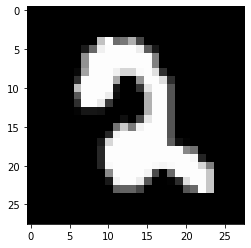

tensor([2])


In [7]:
for x , y in test_dataloader:
    show_tensor_images(x)
    print(y)
    break

In [8]:
pretrained_model = '/content/drive/MyDrive/lenet_mnist_model.pth'

In [9]:
model = Model().to(device)
model.load_state_dict(torch.load(pretrained_model, map_location=device))
model.eval()

Model(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (dropout2d): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
  (dropout1d): Dropout(p=0.5, inplace=False)
  (softmax): Softmax(dim=None)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [10]:
class Conv(nn.Module):
    def __init__(self , 
                 in_channels , 
                 out_channels , 
                 kernel_size = (3 , 3) , 
                 stride = (1 , 1) , 
                 padding = 1 , 
                 use_norm = True , 
                 use_activation = True , 
                 use_pool = True):
        super(Conv , self).__init__()

        self.use_norm = use_norm
        self.use_activation = use_activation
        self.use_pool = use_pool
        
        self.conv = nn.Conv2d(in_channels , 
                              out_channels , 
                              kernel_size , 
                              stride ,
                              padding)
        if self.use_norm:
            self.norm = nn.InstanceNorm2d(out_channels)
        if self.use_activation:
            self.activation = nn.LeakyReLU(0.2)
        if self.use_pool:
            self.maxpool = nn.MaxPool2d(kernel_size = 2 , stride=2)

    def forward(self , x):
        x = self.conv(x)
        if self.use_norm:
            x = self.norm(x)
        if self.use_activation:
            x = self.activation(x)
        if self.use_pool:
            x = self.maxpool(x)
        return x

In [11]:
x = torch.randn(2 , 3 , 512 , 512).to(device)
conv = Conv(3 , 32).to(device)
z = conv(x)
z.shape

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([2, 32, 256, 256])

In [12]:
class ConvT(nn.Module):
    def __init__(self , 
                 in_channels, 
                 out_channels, 
                 kernel_size = (3 , 3) , 
                 stride = (1 , 1) , 
                 padding = 1 , 
                 use_norm = True ,
                 use_activation = True , 
                 use_pool = True):
        super(ConvT , self).__init__()

        self.use_norm = use_norm
        self.use_activation = use_activation
        self.use_pool = use_pool

        self.convT = nn.ConvTranspose2d(in_channels , 
                                        out_channels ,
                                        kernel_size, 
                                        stride , 
                                        padding)
        if self.use_norm:
            self.norm = nn.InstanceNorm2d(out_channels)
        if self.use_activation:
            self.activation = nn.LeakyReLU(0.2)
        if self.use_pool:
            self.maxpool = nn.Upsample(scale_factor=2)

    def forward(self , x):
        x = self.convT(x)
        if self.use_norm:
            x = self.norm(x)
        if self.use_activation:
            x = self.activation(x)
        if self.use_pool:
            x = self.maxpool(x)
        return x

In [13]:
x = torch.randn(2 , 3 , 64 , 64).to(device)
convT = ConvT(3 , 32).to(device)
z = convT(x)
z.shape

torch.Size([2, 32, 128, 128])

In [14]:
class Linear(nn.Module):
    def __init__(self , 
                 in_channels , 
                 out_channels ,
                 use_norm = False , 
                 use_activation = True):
        super(Linear , self).__init__()

        self.use_norm = use_norm
        self.use_activation = use_activation
        self.linear = nn.Linear(in_channels , out_channels)
        
        if self.use_norm:
            self.norm = nn.BatchNorm1d(out_channels)
        if self.use_activation:
            self.activation = nn.LeakyReLU(0.2)

    def forward(self , x):
        x = self.linear(x)
        if self.use_norm:
            x = self.norm(x)
        if self.use_activation:
            x = self.activation(x)
        return x

In [15]:
class Generator(nn.Module):
    def __init__(self ,
                 in_channels = 1 , 
                 out_channels = 1 ,
                 hidden_dim = 32):
        super(Generator , self).__init__()

        self.conv1 = Conv(in_channels , hidden_dim)
        self.conv2 = Conv(hidden_dim  , hidden_dim * 2)
        self.conv3 = Conv(hidden_dim * 2 , hidden_dim * 4)


        self.linear1 = Linear(1152 , hidden_dim * 2)
        self.linear2 = Linear(hidden_dim * 2 , hidden_dim * 2)
        self.linear3 = Linear(hidden_dim * 2 , hidden_dim * 2)
        self.linear4 = Linear(hidden_dim * 2 , 1152)

        self.convT1 = ConvT(hidden_dim * 4 , hidden_dim * 2)
        self.convT2 = ConvT(hidden_dim * 2 , hidden_dim )
        self.convT3 = ConvT(hidden_dim  , out_channels , use_activation=False)
        self.tanh = nn.Tanh()

    def forward(self , x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = torch.flatten(x , start_dim=1)

        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.linear4(x)

        x = x.view(x.shape[0] , 128 , 3 , 3)

        x = self.convT1(x)
        x = F.pad(x , (0 , 1 , 1 , 0) , 'constant' , 0)
        x = self.convT2(x)
        x = self.tanh(self.convT3(x))
        return x

In [16]:
x = torch.randn(2 , 1 , 28 , 28).to(device)
generator = Generator().to(device)
z = generator(x)
z.shape

torch.Size([2, 1, 28, 28])

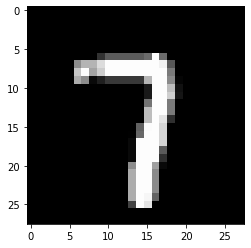

tensor([7])
tensor(7)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [17]:
for x , y in test_dataloader:
    show_tensor_images(x)
    pred = model(x)
    print(y)
    idx = torch.argmax(pred)
    print(idx)
    break

In [18]:
criterion = nn.L1Loss(reduction='sum')

In [19]:
def reranking(y , t , alpha = 1.5):
    if torch.argmax(y) == t:
        y_cp = y.clone().detach()
        y_ = alpha * torch.max(y_cp)
        y_ = torch.clamp(y_ , min=0 , max= 1)
        return y_
    else:
        y = torch.argmax(y)
        return y

In [20]:
generator = Generator().to(device)
lr = 0.002
betas = (0.5 , 0.999)
opt = torch.optim.Adam(generator.parameters() , lr=lr , betas = betas)
display_steps = 10000
epochs = 200
model = Model().to(device)
model.load_state_dict(torch.load(pretrained_model, map_location=device))
model = model.eval()

In [27]:
def get_loss(x , x_ , y , y_ , criterion = criterion , beta = 0.00001):
    loss_x = criterion(x_ , x)
    loss_y = criterion(y_ , y)
    loss = beta * loss_x + loss_y
    return loss

In [28]:
def train():
    target = 7
    cur_step = 0
    mean_generator_loss = 0
    target_output = None
    for epoch in range(epochs):
        for x , y in test_dataloader:
            x , y = x.to(device) , y.to(device)

            opt.zero_grad()

            x_ = generator(x)
            with torch.no_grad():
                y_model_ = model(x)
                y_generator = model(x_)
            y_model = reranking(y_model_ , target)
            y_generator = torch.argmax(y_generator)
            loss = get_loss(x , x_ , y_model , y_generator)

            loss.backward()
            opt.step()

            mean_generator_loss = loss.item()/display_steps

            if cur_step % display_steps == 0:
                print(f'Epochs {epoch} - Step{cur_step} - Mean Generator Loss {mean_generator_loss}')
                print(f'Real pred {y_model} , Adversarial Pred {y_generator}')
                print('Real')
                show_tensor_images(x)
                print('Adversarail Image')
                show_tensor_images(x_)

            cur_step += 1
        mean_generator_loss = 0 

Epochs 0 - Step0 - Mean Generator Loss 0.0006000744819641113
Real pred 1.0 , Adversarial Pred 7
Real


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


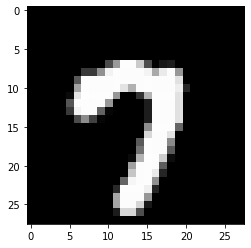

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Adversarail Image


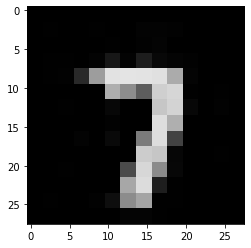

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target output


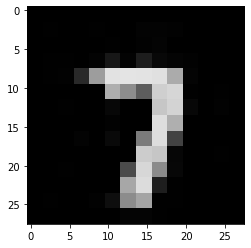

Epochs 1 - Step10000 - Mean Generator Loss 0.0005001030445098876
Real pred 8 , Adversarial Pred 3
Real


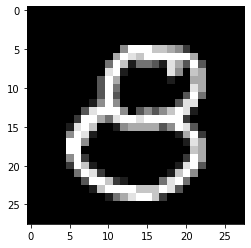

Adversarail Image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


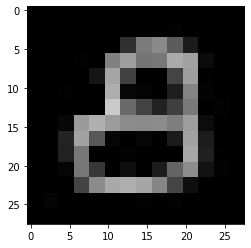

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target output


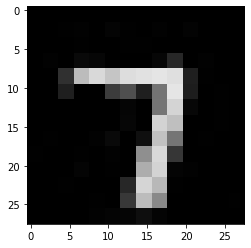

Epochs 2 - Step20000 - Mean Generator Loss 0.00020007548332214356
Real pred 5 , Adversarial Pred 3
Real


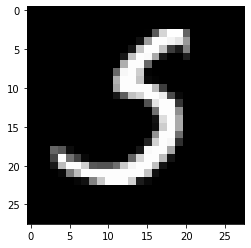

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Adversarail Image


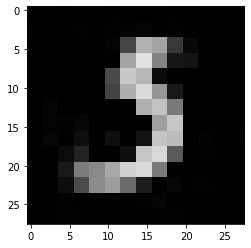

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target output


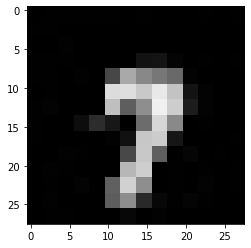

Epochs 3 - Step30000 - Mean Generator Loss 0.00020006859302520752
Real pred 9 , Adversarial Pred 7
Real


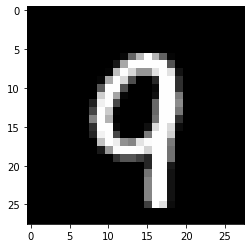

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Adversarail Image


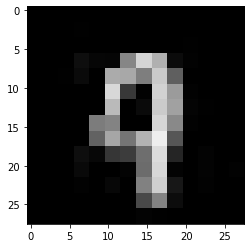

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target output


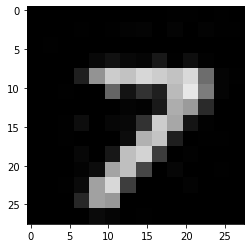

Epochs 4 - Step40000 - Mean Generator Loss 1.0490298736840486e-07
Real pred 3 , Adversarial Pred 3
Real


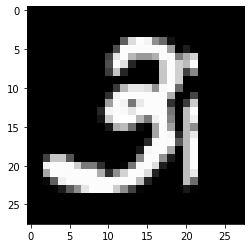

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Adversarail Image


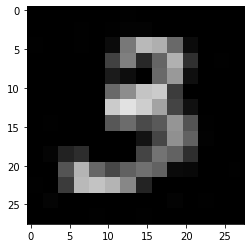

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target output


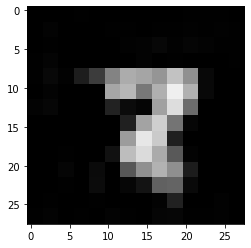

Epochs 5 - Step50000 - Mean Generator Loss 5.239059100858867e-08
Real pred 1 , Adversarial Pred 1
Real


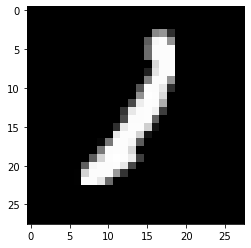

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Adversarail Image


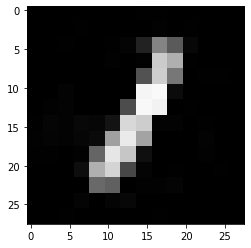

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target output


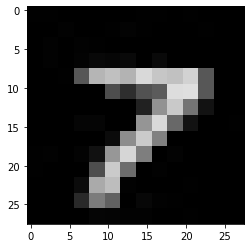

Epochs 6 - Step60000 - Mean Generator Loss 4.9227342242375015e-08
Real pred 1 , Adversarial Pred 1
Real


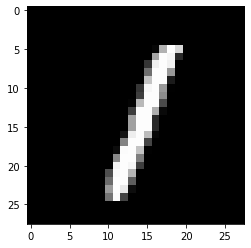

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Adversarail Image


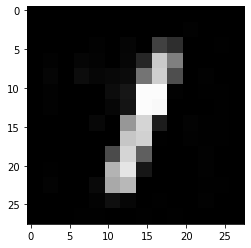

Target output


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


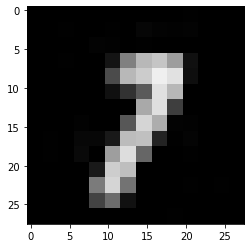

Epochs 7 - Step70000 - Mean Generator Loss 4.7040986828505994e-08
Real pred 1 , Adversarial Pred 1
Real


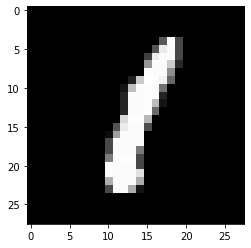

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Adversarail Image


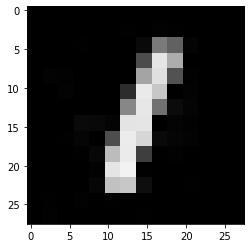

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target output


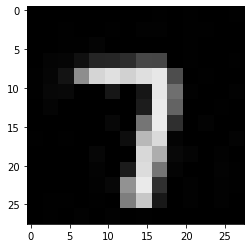

Epochs 8 - Step80000 - Mean Generator Loss 7.716070977039635e-08
Real pred 4 , Adversarial Pred 4
Real


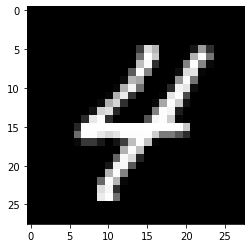

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Adversarail Image


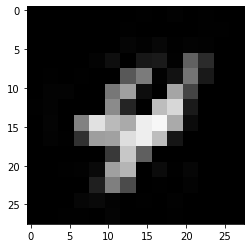

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target output


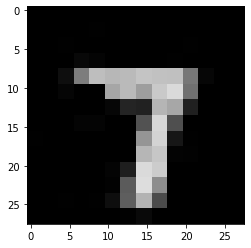

Epochs 9 - Step90000 - Mean Generator Loss 7.689552730880678e-08
Real pred 0 , Adversarial Pred 0
Real


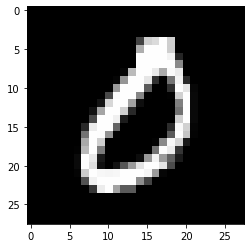

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Adversarail Image


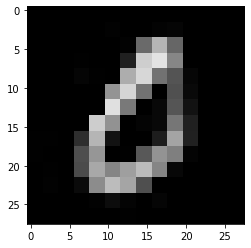

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target output


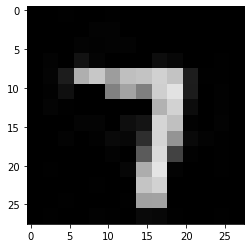

Epochs 10 - Step100000 - Mean Generator Loss 5.2727595902979375e-08
Real pred 1 , Adversarial Pred 1
Real


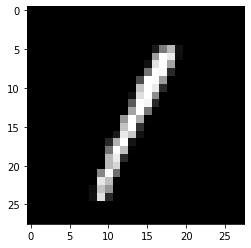

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Adversarail Image


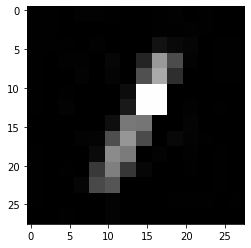

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target output


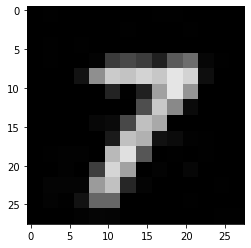

KeyboardInterrupt: ignored

In [29]:
train()

In [39]:
def test(model , generator , dataloader  , device ):
    adv_examples = []
    correct = 0

    for data , target in dataloader:
        data , target = data.to(device) , target.to(device)

   
        output = model(data)
        init_pred = output.max(1 , keepdim = True)[1]

        if init_pred != target:
            continue
        

       
        adversarial_image = generator(data)

        output = model(adversarial_image)
        final_output = output.max(1 , keepdim = True)[1]

        if final_output.item() == target.item():
            correct += 1
        else: 
            adv_ex = adversarial_image.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_output.item(), adv_ex) )
            #print('Appended')

    final_accuracy = correct/float(len(dataloader))
    print("\tTest Accuracy = {} / {} = {}".format(correct, len(dataloader), final_accuracy))
    return final_accuracy , adv_examples

In [40]:
accuracies = []
examples = []
acc, ex = test(model , generator , test_dataloader , device)
accuracies.append(acc)
examples.append(ex)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


	Test Accuracy = 6674 / 10000 = 0.6674


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


391


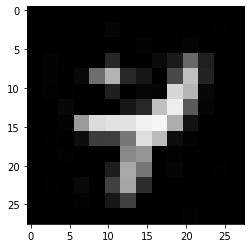

Real pred 4
Adversarial pred 7


In [77]:
i = random.randrange(0 , len(examples[0]))
print(i)
tensor = torch.tensor(examples[0][i][2]).unsqueeze(0)
show_tensor_images(tensor)
print('Real pred' , examples[0][i][0])
print('Adversarial pred' , examples[0][i][1])